##### Copyright 2024 Google LLC.

@Revision: Manuel Lasarte León.

@manuellasarteleon@gmail.com

@manolo@k4r4m310.es

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Visualizing embeddings with t-SNE

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemini-api/tutorials/clustering_with_embeddings"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemini-api/tutorials/clustering_with_embeddings.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemini-api/tutorials/clustering_with_embeddings.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

This tutorial demonstrates how to visualize and perform clustering with the embeddings from the Gemini API. You will visualize a subset of the 20 Newsgroup dataset using [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html){:.external} and cluster that subset using the KMeans algorithm.

For more information on getting started with embeddings generated from the Gemini API, check out the [Python quickstart](https://ai.google.dev/gemini-api/docs/get-started/python#use_embeddings).

## Prerequisites

You can run this quickstart in Google Colab.

To complete this quickstart on your own development environment, ensure that your envirmonement meets the following requirements:

-  Python 3.9+
-  An installation of `jupyter` to run the notebook.

## Setup

First, download and install the Gemini API Python library.

In [1]:
!pip install -U -q google-generativeai

In [12]:
import re
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import google.generativeai as genai

# Used to securely store your API key
from google.colab import userdata

from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Grab an API Key

Before you can use the Gemini API, you must first obtain an API key. If you don't already have one, create a key with one click in Google AI Studio.

<a class="button button-primary" href="https://makersuite.google.com/app/apikey" target="_blank" rel="noopener noreferrer">Get an API key</a>

In Colab, add the key to the secrets manager under the "🔑" in the left panel. Give it the name `API_KEY`.

Once you have the API key, pass it to the SDK. You can do this in two ways:

* Put the key in the `GOOGLE_API_KEY` environment variable (the SDK will automatically pick it up from there).
* Pass the key to `genai.configure(api_key=...)`

In [13]:
# Or use `os.getenv('API_KEY')` to fetch an environment variable.
API_KEY=userdata.get('API_KEY')

genai.configure(api_key=API_KEY)

## Dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html){:.external} contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. For this tutorial, you will be using the training subset.

In [14]:
newsgroups_train = fetch_20newsgroups(subset='train')

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [15]:
# Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
newsgroups_train.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroups_train.data] # Remove email
newsgroups_train.data = [re.sub(r"\([^()]*\)", "", d) for d in newsgroups_train.data] # Remove names
newsgroups_train.data = [d.replace("From: ", "") for d in newsgroups_train.data] # Remove "From: "
newsgroups_train.data = [d.replace("\nSubject: ", "") for d in newsgroups_train.data] # Remove "\nSubject: "

In [16]:
# Put training points into a dataframe
df_train = pd.DataFrame(newsgroups_train.data, columns=['Text'])
df_train['Label'] = newsgroups_train.target
# Match label to target name index
df_train['Class Name'] = df_train['Label'].map(newsgroups_train.target_names.__getitem__)
# Retain text samples that can be used in the gecko model.
df_train = df_train[df_train['Text'].str.len() < 10000]

# df_train

Key Point: Next, you will choose a model. Any embedding model will work for this tutorial, but for real applications it's important to choose a specific model and stick with it. The outputs of different models are not compatible with each other.

**Note**: At this time, the Gemini API is [only available in certain regions](https://ai.google.dev/gemini-api/docs/available-regions).

In [17]:
# Take a sample of each label category from df_train
SAMPLE_SIZE = 150
df_train = (df_train.groupby('Label', as_index = False)
                    .apply(lambda x: x.sample(SAMPLE_SIZE))
                    .reset_index(drop=True))

# Choose categories about science
df_train = df_train[df_train['Class Name'].str.contains('sci')]

# Reset the index
df_train = df_train.reset_index()
# df_train

<ipython-input-17-05af0628b6ba>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(SAMPLE_SIZE))


In [21]:
import sys
from tqdm.auto import tqdm
tqdm.pandas()

from google.api_core import retry

def make_embed_text_fn(model):

  @retry.Retry(timeout=800.0)
  def embed_fn(text: str) -> list[float]:
    # Set the task_type to CLUSTERING.
    # Truncate the text to the maximum allowed size in bytes

 # Ensure text size is within the limit before encoding
    text = text[:5000]  # Truncate by characters first

    # Encode and truncate by bytes if necessary
    encoded_text = text.encode('utf-8')
    if len(encoded_text) > 10000:
      encoded_text = encoded_text[:10000]
    text = encoded_text.decode('utf-8', 'ignore')

    tamano_bytes = sys.getsizeof(text)
    print(tamano_bytes, len(text))


    embedding = genai.embed_content(model=model,
                                    content=text,
                                    task_type="clustering")
    return embedding["embedding"]

  return embed_fn

def create_embeddings(df):
  model = 'models/embedding-001'
  df['Embeddings'] = df['Text'].progress_apply(make_embed_text_fn(model))
  return df

df_train = create_embeddings(df_train)

  0%|          | 0/600 [00:00<?, ?it/s]

604 555
713 664
274 225
732 683
987 938
2740 2691
2786 2737
1128 1079
4414 4365
1654 1605
971 922
2898 2849
2460 2411
1647 1598
1906 1857
2507 2458
2650 2601
1952 1903
3355 3306
1863 1814
4798 4749
1356 1307
435 386
2764 2715
2547 2498
727 678
1449 1400
2288 2239
2288 2239
1204 1155
796 747
2078 2029
929 880
1961 1912
907 858
2275 2226
1352 1303
531 482
1142 1093
1400 1351
3274 3225
1197 1148
2015 1966
1523 1474
1974 1925
1135 1086
886 837
379 330
1441 1392
2529 2480
1471 1422
557 508
841 792
3201 3152
765 716
5049 5000
2253 2204
802 753
1622 1573
796 747
699 650
814 765
820 771
643 594
1046 997
865 816
3466 3417
906 857
1075 1026
1225 1176
1243 1194
5049 5000
1830 1781
1040 991
1134 1085
1027 978
2530 2481
591 542
968 919
3127 3078
5049 5000
1039 990
5049 5000
2717 2668
4796 4747
260 211
915 866
1070 1021
1092 1043
407 358
775 726
769 720
1232 1183
1914 1865
741 692
571 522
3609 3560
1199 1150
437 388
782 733
383 334
2256 2207
2057 2008
3122 3073
1585 1536
773 724
634 585
2148 2099
11

In [22]:
for m in genai.list_models():
  if 'embedContent' in m.supported_generation_methods:
    print(m.name)

models/embedding-001
models/text-embedding-004


Here is the first example in the training set.

In [23]:
idx = newsgroups_train.data[0].index('Lines')
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







Next, you will sample some of the data by taking 100 data points in the training dataset, and dropping a few of the categories to run through this tutorial. Choose the science categories to compare.

In [24]:
df_train['Class Name'].value_counts()

,count
Class Name,
sci.crypt,150
sci.electronics,150
sci.med,150
sci.space,150


## Create the embeddings

In this section, you will see how to generate embeddings for the different texts in the dataframe using the embeddings from the Gemini API.

### API changes to Embeddings with model embedding-001

For the new embeddings model, embedding-001, there is a new task type parameter and the optional title (only valid with task_type=`RETRIEVAL_DOCUMENT`).

These new parameters apply only to the newest embeddings models.The task types are:

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.

## Dimensionality reduction

The length of the document embedding vector is 768. In order to visualize how the embedded documents are grouped together, you will need to apply dimensionality reduction as you can only visualize the embeddings in 2D or 3D space. Contextually similar documents should be closer together in space as opposed to documents that are not as similar.

In [25]:
len(df_train['Embeddings'][0])

768

In [26]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train['Embeddings'].to_list(), dtype=np.float32)
X.shape

(600, 768)

You will apply the t-Distributed Stochastic Neighbor Embedding (t-SNE) approach to perform dimensionality reduction. This technique reduces the number of dimensions, while preserving clusters (points that are close together stay close together). For the original data, the model tries to construct a distribution over which other data points are "neighbors" (e.g., they share a similar meaning). It then optimizes an objective function to keep a similar distribution in the visualization.

In [27]:
tsne = TSNE(random_state=0, n_iter=1000)
tsne_results = tsne.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [28]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Class Name'] = df_train['Class Name'] # Add labels column from df_train to df_tsne
df_tsne

,TSNE1,TSNE2,Class Name
0,-40.907829,-6.817593,sci.crypt
1,-19.346930,-22.032499,sci.crypt
2,-20.358080,-3.182119,sci.crypt
3,-35.687210,-16.681271,sci.crypt
4,-21.577646,-23.911222,sci.crypt
...,...,...,...
595,7.922698,20.097422,sci.space
596,13.487432,25.752382,sci.space
597,8.935733,11.203433,sci.space
598,24.901831,23.198483,sci.space


(-49.63735065460205, 48.48637638092041, -31.422770023345947, 37.01177263259888)

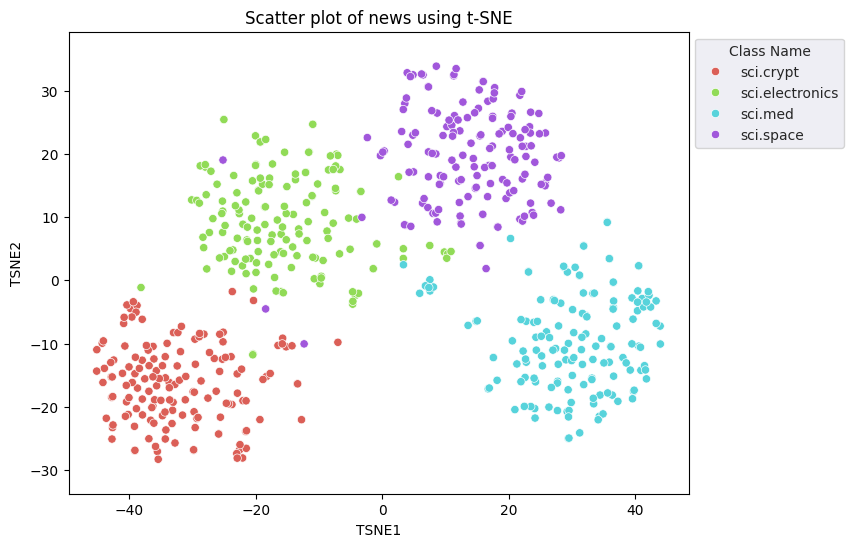

In [29]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='hls')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

## Compare results to KMeans

[KMeans clustering](https://developers.google.com/machine-learning/glossary#k-means){:.external} is a popular clustering algorithm and used often for unsupervised learning. It iteratively determines the best k center points, and assigns each example to the closest centroid. Input the embeddings directly into the KMeans algorithm to compare the visualization of the embeddings to the performance of a machine learning algorithm.

In [30]:
# Apply KMeans
kmeans_model = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(X)
labels = kmeans_model.fit_predict(X)

In [31]:
df_tsne['Cluster'] = labels
df_tsne

,TSNE1,TSNE2,Class Name,Cluster
0,-40.907829,-6.817593,sci.crypt,1
1,-19.346930,-22.032499,sci.crypt,0
2,-20.358080,-3.182119,sci.crypt,0
3,-35.687210,-16.681271,sci.crypt,1
4,-21.577646,-23.911222,sci.crypt,1
...,...,...,...,...
595,7.922698,20.097422,sci.space,2
596,13.487432,25.752382,sci.space,2
597,8.935733,11.203433,sci.space,2
598,24.901831,23.198483,sci.space,2


(-49.63735065460205, 48.48637638092041, -31.422770023345947, 37.01177263259888)

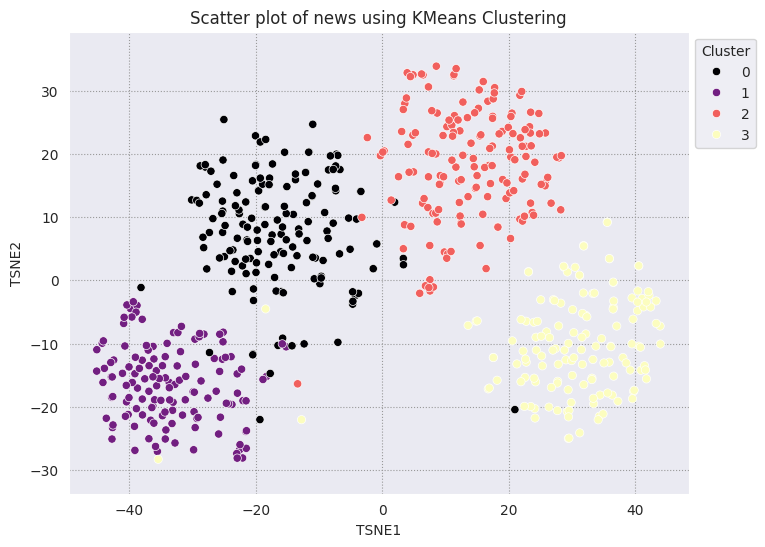

In [32]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Cluster', palette='magma')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using KMeans Clustering');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

In [33]:
def get_majority_cluster_per_group(df_tsne_cluster, class_names):
  class_clusters = dict()
  for c in class_names:
    # Get rows of dataframe that are equal to c
    rows = df_tsne_cluster.loc[df_tsne_cluster['Class Name'] == c]
    # Get majority value in Cluster column of the rows selected
    cluster = rows.Cluster.mode().values[0]
    # Populate mapping dictionary
    class_clusters[c] = cluster
  return class_clusters

In [34]:
classes = df_tsne['Class Name'].unique()
class_clusters = get_majority_cluster_per_group(df_tsne, classes)
class_clusters

{'sci.crypt': 1, 'sci.electronics': 0, 'sci.med': 3, 'sci.space': 2}

Get the majority of clusters per group, and see how many of the actual members of that group are in that cluster.

In [35]:
# Convert the Cluster column to use the class name
class_by_id = {v: k for k, v in class_clusters.items()}
df_tsne['Predicted'] = df_tsne['Cluster'].map(class_by_id.__getitem__)

# Filter to the correctly matched rows
correct = df_tsne[df_tsne['Class Name'] == df_tsne['Predicted']]

# Summarise, as a percentage
acc = correct['Class Name'].value_counts() / SAMPLE_SIZE
acc

,count
Class Name,
sci.space,0.973333
sci.electronics,0.953333
sci.med,0.940000
sci.crypt,0.920000


In [36]:
# Get predicted values by name
df_tsne['Predicted'] = ''
for idx, rows in df_tsne.iterrows():
  cluster = rows['Cluster']
  # Get key from mapping based on cluster value
  key = list(class_clusters.keys())[list(class_clusters.values()).index(cluster)]
  df_tsne.at[idx, 'Predicted'] = key

df_tsne

,TSNE1,TSNE2,Class Name,Cluster,Predicted
0,-40.907829,-6.817593,sci.crypt,1,sci.crypt
1,-19.346930,-22.032499,sci.crypt,0,sci.electronics
2,-20.358080,-3.182119,sci.crypt,0,sci.electronics
3,-35.687210,-16.681271,sci.crypt,1,sci.crypt
4,-21.577646,-23.911222,sci.crypt,1,sci.crypt
...,...,...,...,...,...
595,7.922698,20.097422,sci.space,2,sci.space
596,13.487432,25.752382,sci.space,2,sci.space
597,8.935733,11.203433,sci.space,2,sci.space
598,24.901831,23.198483,sci.space,2,sci.space


To better visualize the performance of the KMeans applied to your data, you can use a [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). The confusion matrix allows you to assess the performance of the classification model beyond accuracy. You can see what misclassified points get classified as. You will need the actual values and the predicted values, which you have gathered in the dataframe above.

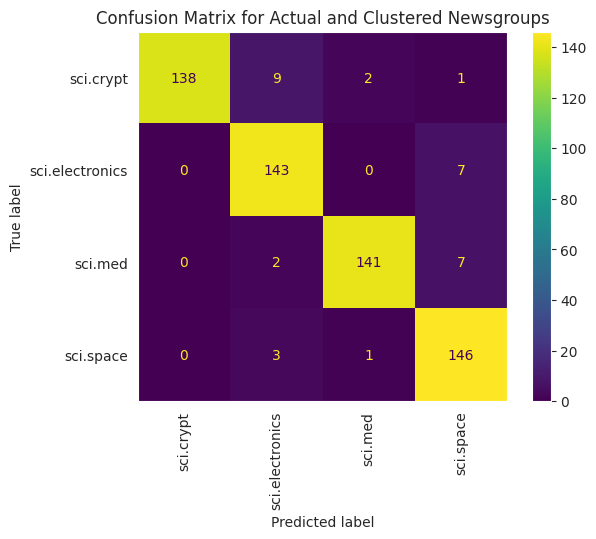

In [37]:
cm = confusion_matrix(df_tsne['Class Name'].to_list(), df_tsne['Predicted'].to_list())
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot(xticks_rotation='vertical')
plt.title('Confusion Matrix for Actual and Clustered Newsgroups');
plt.grid(False)

## Next steps

You've now created your own visualization of embeddings with clustering! Try using your own textual data to visualize them as embeddings. You can perform dimensionality reduction in order to complete the visualization step. Note that TSNE is good at clustering inputs, but can take a longer time to converge or might get stuck at local minima. If you run into this issue, another technique you could consider are [principal components analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis){:.external}.

There are other clustering algorithms outside of KMeans as well, such as [density-based spatial clustering (DBSCAN)](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html){:.external}.

To learn how to use other services in the Gemini API, see the [Python quickstart](https://ai.google.dev/tutorials/python_quickstart).

To learn more about how you can use embeddings, see these  other tutorials:

 * [Anomaly Detection with Embeddings](https://ai.google.dev/gemini-api/tutorials/anomaly_detection)
 * [Document Search with Embeddings](https://ai.google.dev/gemini-api/tutorials/document_search)
 * [Training a Text Classifier with Embeddings](https://ai.google.dev/gemini-api/tutorials/text_classifier_embeddings)